# Imports

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
from warnings import filterwarnings
filterwarnings('ignore')
from ipynb.fs.full.helper import get_linear_reg, get_quadratic_reg, plot_confusion_matrix, fit_model, eval_pred, eval_model

# Load Data

In [2]:
df = pd.read_csv('../data/test_set.csv', parse_dates=['timestamp'])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 7 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   Unnamed: 0               200000 non-null  int64         
 1   _temporary_index_column  200000 non-null  int64         
 2   patient_id               200000 non-null  int64         
 3   timestamp                200000 non-null  datetime64[ns]
 4   measurement_x            200000 non-null  float64       
 5   measurement_y            200000 non-null  float64       
 6   measurement_z            200000 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(3)
memory usage: 10.7 MB


# Feature Engineering

## Group Measures by Patient

In [4]:
MEASUREMENTS = ['measurement_x', 'measurement_y', 'measurement_z']

In [5]:
features = [df.groupby('patient_id')[measure].apply(list) for measure in MEASUREMENTS]
df_patients = pd.concat(features, axis=1).reset_index()

## Statistical Measures by Patient

In [6]:
for measure in MEASUREMENTS:
    df_patients[f'{measure}_std'] = df_patients[measure].apply(np.std)
    df_patients[f'{measure}_mean'] = df_patients[measure].apply(np.mean)    
    df_patients[f'{measure}_median'] = df_patients[measure].apply(np.median)

## Linear Regression Measures by Patient

In [7]:
for measure in MEASUREMENTS:
    df_patients[[f'{measure}_lr_slope', f'{measure}_lr_corr']] = df_patients.apply(lambda row: get_linear_reg(row[measure]), axis=1, result_type="expand")

## Quadratic Regression Measures by Patient

In [8]:
for measure in MEASUREMENTS:
    df_patients[[f'{measure}_quad_a', f'{measure}_quad_b']] = df_patients.apply(lambda row: get_quadratic_reg(row[measure]), axis=1, result_type="expand")

# Model

In [9]:
model_df = df_patients.drop(['patient_id', 'measurement_x', 'measurement_y', 'measurement_z'], axis=1)

In [10]:
bst = lgb.Booster(model_file='../artifacts/model.txt')

In [11]:
y_pred = bst.predict(model_df)

In [12]:
y_hat = [np.argmax(pred) for pred in y_pred]

<AxesSubplot:ylabel='None'>

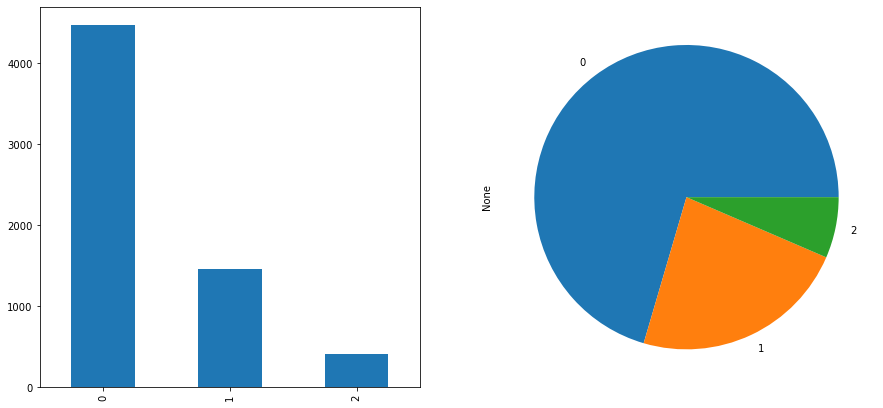

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
pd.Series(y_hat).value_counts().plot(kind='bar', ax=ax1)
pd.Series(y_hat).value_counts().plot.pie(ax=ax2)

In [14]:
df_predictions = pd.concat([pd.Series(y_hat, name='label'), df_patients['patient_id']], axis=1)

In [15]:
df_predictions.to_csv('../artifacts/predictions.csv', index=False)